In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import xarray as xr
import numpy as np
from metpy.calc import potential_temperature
from metpy.units import units
import pandas as pd
from netCDF4 import Dataset

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.transforms import offset_copy

In [5]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('colorbar', fontsize=12)
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ObsData 

In [6]:
oli_ccn_data = xr.open_mfdataset("../data/obs/OLI/oliaoscpcuM1.*.nc")
oli_rad = xr.open_mfdataset('../data/obs/OLI/olikazrgeM1.*.nc')["reflectivity"]
oli_snd = xr.open_dataset("../data/obs/OLI/olisondewnpnM1.b1.20170511.232900.cdf")
oli_tht = potential_temperature(oli_snd.pres * units["hPa"], oli_snd.tdry * units.degC)
oli_snd_hgt = oli_snd.alt
oli_rh = oli_snd.rh

In [7]:
oli_model_theta = xr.open_dataset('../data/model/oliktok.nc').isel(time=0)['THETA']
oli_model_heights = oli_model_theta.z.values

aerosol data is very dirty, so let's filter out everything > 1000 1/cm3

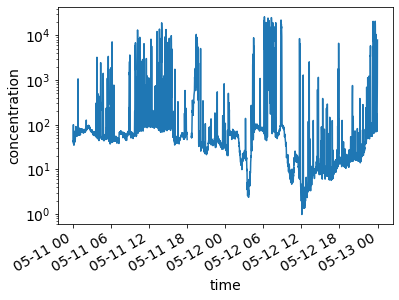

In [8]:
oli_ccn_data.concentration.resample(time='1T').mean().plot(yscale='log')

In [9]:
oli_ccn = oli_ccn_data.concentration.where(oli_ccn_data.qc_concentration ==0).where(oli_ccn_data.concentration < 1000).resample(time='10T').mean()

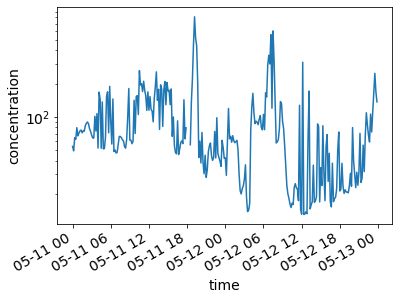

In [10]:
oli_ccn.plot(yscale='log')

# Reanalysis Data

In [11]:
class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


In [12]:
loc = Location('OLI', 70.49525, -149.88688)

In [13]:
centlat, centlon = loc.lat, loc.lon
lat1, lat2 = centlat - 20, centlat + 10
lon1, lon2 = centlon + 360 -30, centlon + 360 + 30

In [14]:
data_mslp = xr.open_dataset('../data/obs/OLI/e5.oper.an.sfc.128_151_msl.ll025sc.2017050100_2017053123.nc')
data_temp = xr.open_dataset('../data/obs/OLI/e5.oper.an.sfc.128_167_2t.ll025sc.2017050100_2017053123.nc')

In [15]:
# subset = dict(latitude=slice(lat2, lat1), longitude=slice(lon1, lon2), time=np.datetime64('2017-05-12T09:00:00'))
subset = dict(time=np.datetime64('2017-05-12T09:00:00'), longitude=slice(160, 260), latitude=slice(lat2, lat1))


In [16]:
lon1,lon2

(180.11312, 240.11312)

In [17]:
mslp = data_mslp.MSL.sel(**subset)/ 100
temp = data_temp.VAR_2T.sel(**subset) 

In [18]:
plev = np.arange(700, 1100, 2)

In [19]:
stime = pd.to_datetime(mslp.time.values).strftime('%Y-%m-%d %Hz')

# Plot

In [20]:
plt.rcParams['figure.constrained_layout.use'] = True

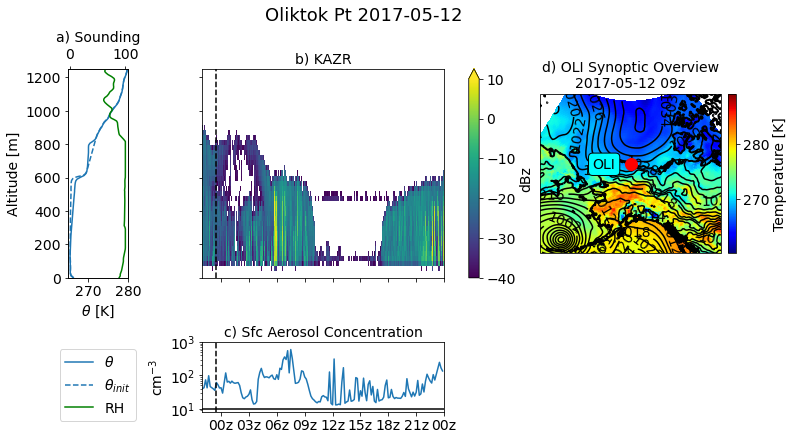

In [23]:
fig = plt.figure(figsize=(10,6))

t1 = np.datetime64("2017-05-11T22:00:00")
t2 = np.datetime64("2017-05-13T00:00:00")

snd_time = oli_snd.time[0].values

gs = GridSpec(2, 3, figure=fig, height_ratios=[3,1], width_ratios=[1,4,3])

ax1 = fig.add_subplot(gs[0,0])
axl = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[0,2], projection=ccrs.LambertConformal(central_latitude=centlat, central_longitude=centlon))

p1 = ax1.plot(oli_tht, oli_snd_hgt, label='$\\theta$')
p3 = ax1.plot(oli_model_theta, oli_model_heights, color='C0', linestyle='dashed', label='$\\theta_{init}$')
ax1.set_ylim(0, 1250)
ax1.set_xlim(265, 280)
ax1.set_xlabel("$\\theta$ [K]")
ax1.set_ylabel('Altitude [m]')
# ax1.set_title("Sounding")
# ax1.sharey(ax2)
axrh = ax1.twiny()
p2 = axrh.plot(oli_rh, oli_snd_hgt, color='g', label='RH')
# axrh.set_xlabel("a) RH [%]")
ax1.set_title("a) Sounding")

labs = [l.get_label() for l in (p1+p3+p2)]
axl.legend(p1+p3+p2, labs, loc='upper center')
axl.spines['top'].set_visible(False)
axl.spines['right'].set_visible(False)
axl.spines['bottom'].set_visible(False)
axl.spines['left'].set_visible(False)
axl.get_xaxis().set_ticks([])
axl.get_yaxis().set_ticks([])
# rad = ax2.pcolormesh(oli_rad.time, oli_rad.range, oli_rad.T, shading="auto", vmin=-60, vmax=10)
oli_rad.sel(time=slice(t1,t2)).where(oli_rad.sel(time=slice(t1,t2)) >=-40).plot.pcolormesh(
    x='time', y='range', ax=ax2, shading='auto', vmin=-40, vmax=10, cbar_kwargs=dict(label="dBz"),
    add_labels=False
)
ax2.set_ylim(0, 1250)
# plt.colorbar(rad, ax=ax2, label='dBz')
ax2.set_title("b) KAZR")
# ax2.set_ylabel("Height [m]")
# ax2.set_xticklabels(ax2.get_xticks(), rotation=0, ha='center')
# ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Hz"))
ax2.set_xlim(t1, t2)
ax2.axvline(snd_time, color='k', linestyle='dashed')
ax2.set_ylabel("")

ax2.set_xticklabels([""])
ax2.set_yticklabels([""])

# ax3.sharex(ax2)
# ax1.sharey(ax2)


ax3.set_xlim(t1, t2)
ax3.plot(oli_ccn.time, oli_ccn)
# ax3.yaxis.set_label_position("right")
# ax3.yaxis.tick_right()
ax3.set_title("c) Sfc Aerosol Concentration")
ax3.set_yticks([10, 1e2, 1e3, 1e4])
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Hz'))
# ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45, horizontalalignment='right')
plt.suptitle("Oliktok Pt 2017-05-12")
ax3.axhline(10, color='k')
ax3.set_ylabel('cm$^{-3}$')
ax3.axvline(snd_time, color='k', linestyle='dashed')
ax3.set_yscale('log')
# plt.tight_layout()


ax4.set_extent((lon1, lon2, lat1, lat2))
t = ax4.pcolormesh(temp.longitude, temp.latitude, temp, transform=ccrs.PlateCarree(), cmap='jet')
p = ax4.contour(mslp.longitude, mslp.latitude, mslp, transform=ccrs.PlateCarree(), colors='k', levels=plev)

ax4.clabel(p, inline=True, manual=False, zorder=1)

cartopy_transform = ccrs.PlateCarree()._as_mpl_transform(ax4)
text_transform = offset_copy(cartopy_transform, units='dots', x=-15)
                             
text_kwargs = dict(verticalalignment='center', horizontalalignment='right', transform=text_transform,
        bbox={
            'facecolor':'aqua',
            'alpha' : 1,
            'boxstyle' : 'round',
            'zorder':10
        }
)

ax4.plot(loc.lon, loc.lat, marker='o', color='red', markersize=12, transform=ccrs.PlateCarree())
ax4.text(loc.lon, loc.lat, loc.name, **text_kwargs)

ax4.coastlines(color='k', linewidth=2)
ax4.set_title(f"d) {loc.name} Synoptic Overview\n{stime}")

plt.draw()
posn = ax4.get_position()
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0, 0.01, posn.height])

plt.colorbar(t, label='Temperature [K]', cax=cbar_ax)

plt.savefig("obs_oli.png", facecolor="w")